# Librerias

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,8)


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn import tree



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Cargamos datos

In [2]:
df = pd.read_csv('../01_data/train.csv', index_col = 0)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
0,0.30,Premium,D,SI2,62.4,58.0,4.31,4.28,2.68,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,6.42,6.46,4.04,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,5.71,5.74,3.54,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,6.54,6.50,4.12,8.371
4,0.36,Premium,G,VS1,62.3,59.0,4.50,4.55,2.82,6.588


# Descripción de los datos

**carat**: Representa el peso del diamante en quilates. Es una variable numérica.

**cut**: Describe la calidad del tallado del diamante. Es una variable categórica.

**color**: Indica la percepción de color del diamante. También es una variable categórica.

**clarity**: Describe la claridad del diamante en términos de imperfecciones. Es una variable categórica.

**depth**: Representa la altura del diamante en relación con el diámetro máximo. Es una variable numérica.

**table**: Indica el ancho de la parte superior del diamante en relación con el diámetro máximo. Es una variable numérica.

**x, y, z**: Representan las dimensiones del diamante en milímetros. Todas son variables numéricas.

**price**: Es la variable respuesta, que representa el precio del diamante en unidades de la moneda del dataset. Es una variable numérica.

# Análisis exploratorio

In [3]:
# Vemos la estructura de nuestro data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40455 entries, 0 to 40454
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    40455 non-null  float64
 1   cut      40455 non-null  object 
 2   color    40455 non-null  object 
 3   clarity  40455 non-null  object 
 4   depth    40455 non-null  float64
 5   table    40455 non-null  float64
 6   x        40455 non-null  float64
 7   y        40455 non-null  float64
 8   z        40455 non-null  float64
 9   price    40455 non-null  float64
dtypes: float64(7), object(3)
memory usage: 3.4+ MB


In [4]:
df.select_dtypes(include = np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
carat,40455.0,0.797576,0.475939,0.200,0.400,0.70,1.040,5.010
depth,40455.0,61.746377,1.436796,43.000,61.000,61.80,62.500,79.000
table,40455.0,57.451694,2.234569,44.000,56.000,57.00,59.000,95.000
x,40455.0,5.729163,1.125244,0.000,4.710,5.69,6.540,10.740
y,40455.0,5.732896,1.154799,0.000,4.720,5.70,6.540,58.900
z,40455.0,3.537351,0.711002,0.000,2.910,3.52,4.030,31.800
price,40455.0,7.783822,1.016828,5.787,6.851,7.78,8.581,9.842


## Nulos y duplicados

In [5]:
(df.isnull().sum() / df.shape[0]) * 100

carat      0.0
cut        0.0
color      0.0
clarity    0.0
depth      0.0
table      0.0
x          0.0
y          0.0
z          0.0
price      0.0
dtype: float64

Me aparece que no hay nulos, pero en las columnas 'x', 'y' y 'z' el minimo es 0, así que si que hay nulos, vamos a ver cuantos tenemos:

In [6]:
num_zeros = (df['x'] == 0).sum()
print(f'Número de ceros en la columna "x": {num_zeros}')

Número de ceros en la columna "x": 7


In [7]:
num_zeros = (df['y'] == 0).sum()
print(f'Número de ceros en la columna "x": {num_zeros}')

Número de ceros en la columna "x": 6


In [8]:
num_zeros = (df['z'] == 0).sum()
print(f'Número de ceros en la columna "x": {num_zeros}')

Número de ceros en la columna "x": 17


Al ser una proporción pequeña vamos a eliminarlos:

In [9]:
# Reemplazamos los valores '0' por NaN en las columnas 'x', 'y' y 'z'
df[['x', 'y', 'z']] = df[['x', 'y', 'z']].replace(0, np.nan)

# Eliminamos las filas que contienen NaN en las columnas 'x', 'y' y 'z'
df = df.dropna(subset=['x', 'y', 'z'])

In [10]:
# Verificamos si hay filas duplicadas
df[df.duplicated()]

,carat,cut,color,clarity,depth,table,x,y,z,price
id,,,,,,,,,,
2746,0.43,Ideal,G,VS1,61.9,55.0,4.84,4.86,3.00,6.849
7158,0.35,Premium,J,VS1,62.4,58.0,5.67,5.64,3.53,6.855
7672,0.41,Ideal,G,IF,61.7,56.0,4.77,4.80,2.95,7.220
8184,1.00,Fair,F,SI2,65.1,55.0,6.26,6.23,4.07,8.091
9493,2.00,Premium,G,SI2,60.7,60.0,8.13,8.07,4.92,9.290
...,...,...,...,...,...,...,...,...,...,...
39243,0.53,Premium,E,SI2,62.2,57.0,5.20,5.16,3.22,6.892
39283,2.05,Premium,G,SI1,61.6,59.0,8.20,8.16,5.04,9.635
39955,0.52,Ideal,D,VS2,61.8,55.0,5.19,5.16,3.20,7.560


Vemos que hay 85 filas duplicadas de 40455, por lo que vamos a eliminarlas, ya que es una cantidad proporcionalmente pequeña:

In [11]:
df.drop_duplicates(inplace=True)

## Distribución

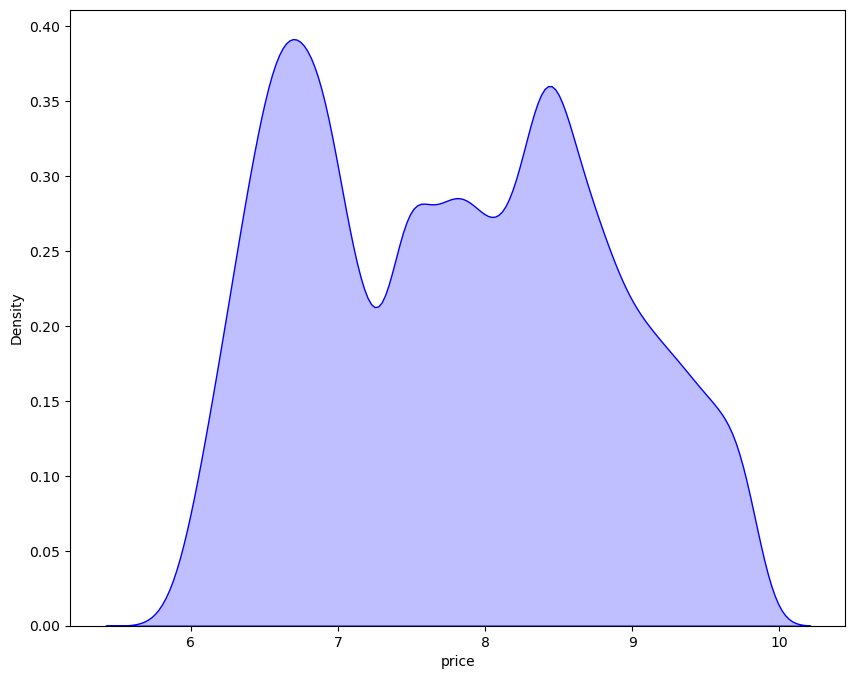

In [12]:
# vamos a ver visualmente como está distribuida la variable respuesta

sns.distplot(
    df.price, 
    hist = False, 
    color = "blue", 
    kde_kws = {"shade": True, "linewidth": 1});

La distrubución de la variable respuesta no es normal, por lo que deberemos hacer una normalización más adelante.

In [13]:
# exploramos cuáles son los principales estadísticos de las variables numéricas

df.select_dtypes(include = np.number).describe().T

,count,mean,std,min,25%,50%,75%,max
carat,40354.0,0.797175,0.475213,0.200,0.400,0.70,1.04000,5.010
depth,40354.0,61.745031,1.436016,43.000,61.000,61.80,62.50000,79.000
table,40354.0,57.452800,2.234866,44.000,56.000,57.00,59.00000,95.000
x,40354.0,5.729692,1.121938,3.730,4.710,5.69,6.54000,10.740
y,40354.0,5.733340,1.152070,3.680,4.720,5.70,6.54000,58.900
z,40354.0,3.538778,0.707088,1.070,2.910,3.52,4.03000,31.800
price,40354.0,7.783649,1.016550,5.787,6.851,7.78,8.58075,9.842


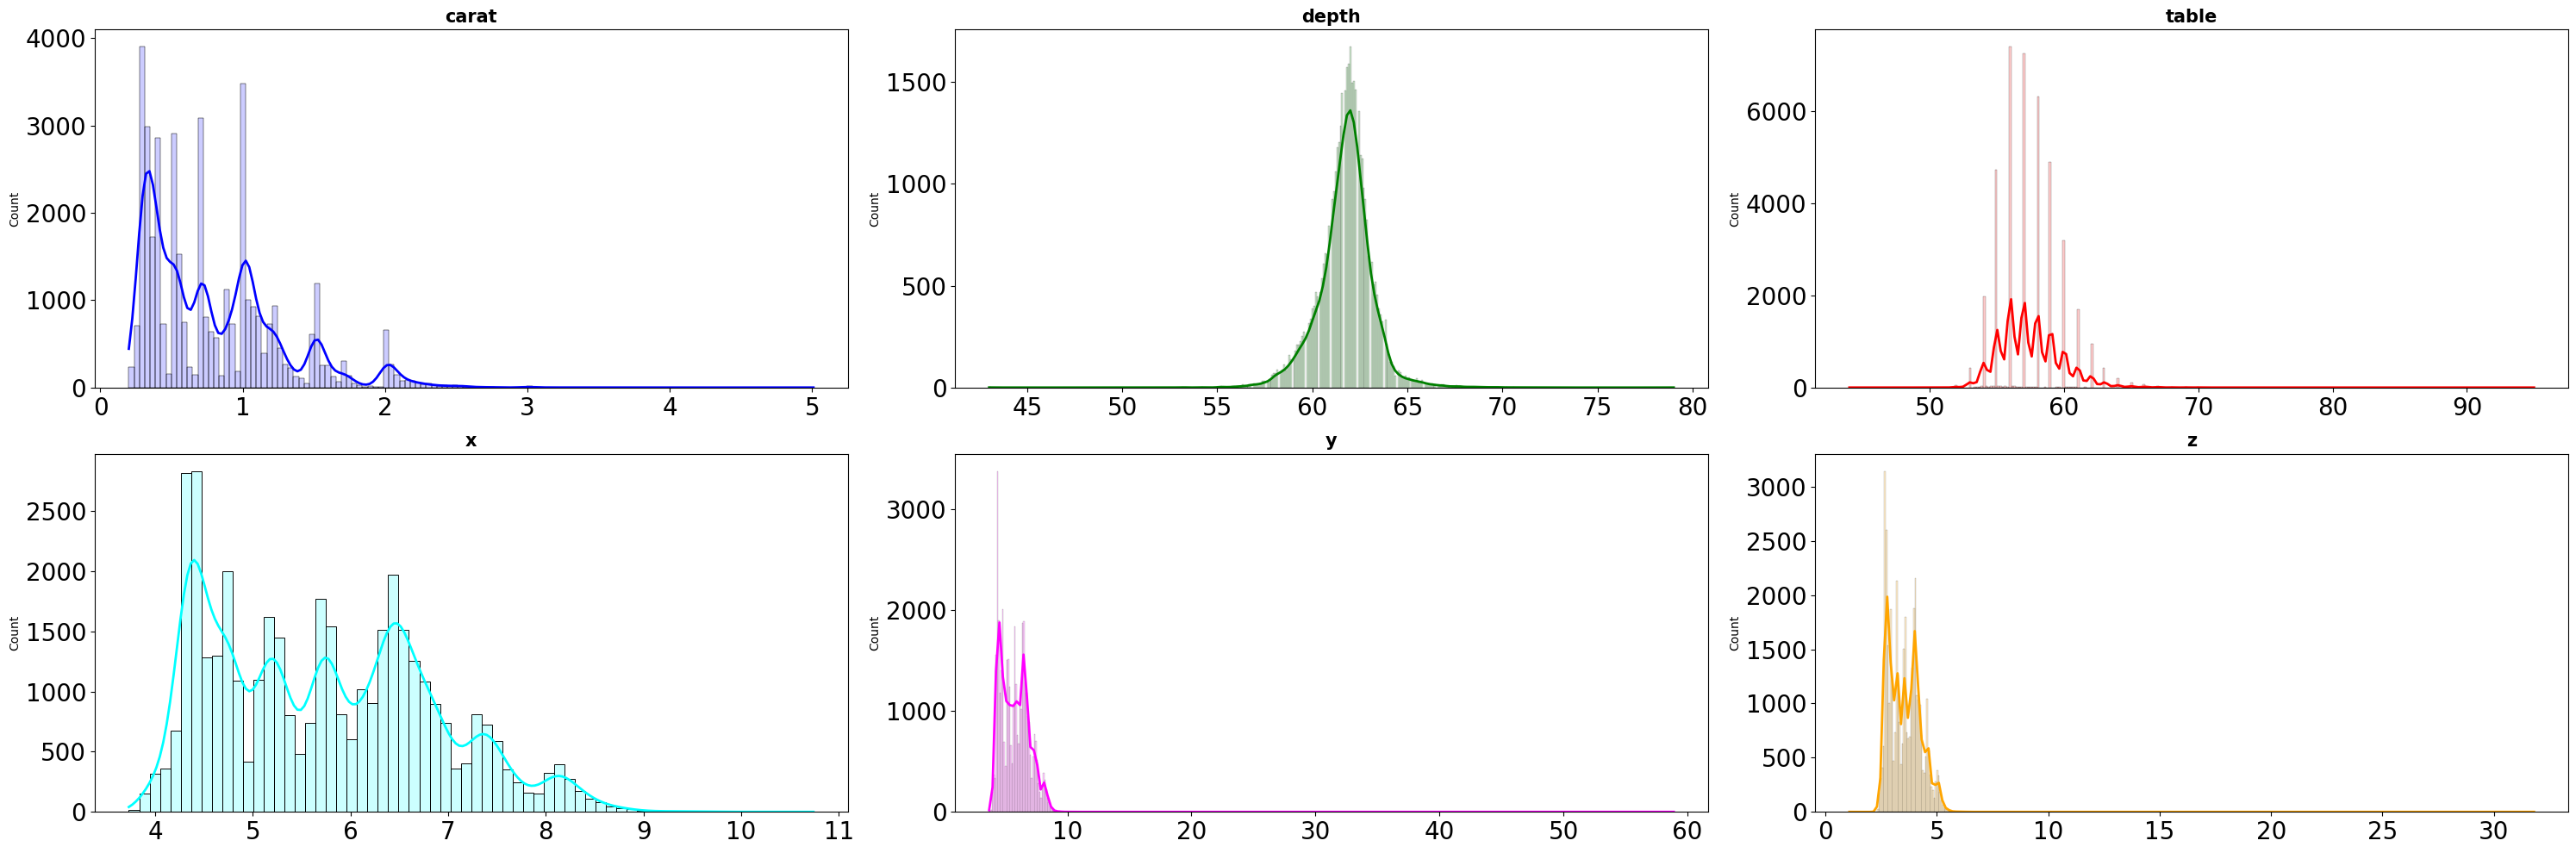

In [14]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("price")

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df,
        x = colum,
        kde = True, 
        color = lista_colores[i], 
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    

fig.tight_layout()
#fig.delaxes(axes[-1]) # Eliminamos el último eje que no se usa;

## Relación y correlación de las variables

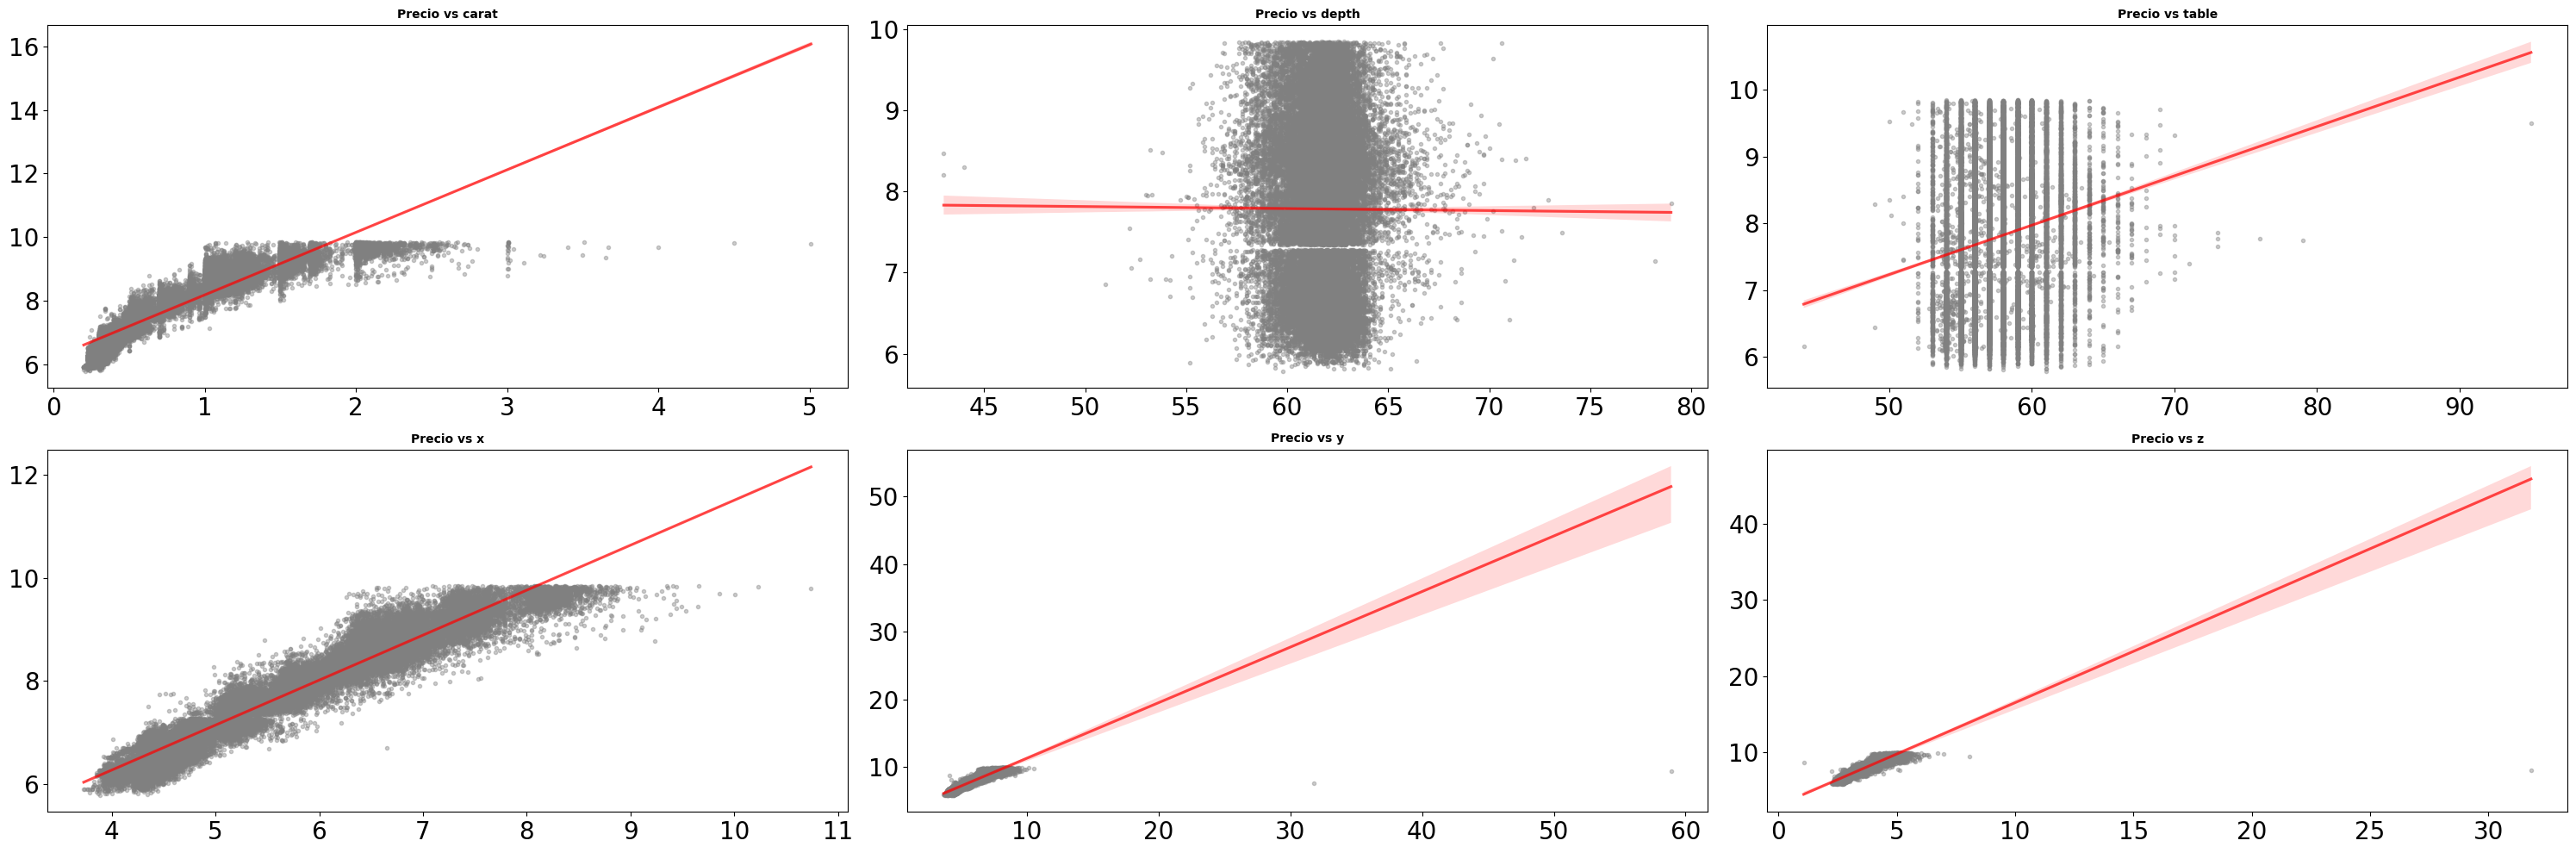

In [15]:
# Gráfico de relación entre variables predictoras y la variable a predecir
# ==============================================================================


fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("price")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df[colum], 
        y = df["price"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Precio vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout()
#fig.delaxes(axes[-1]) 

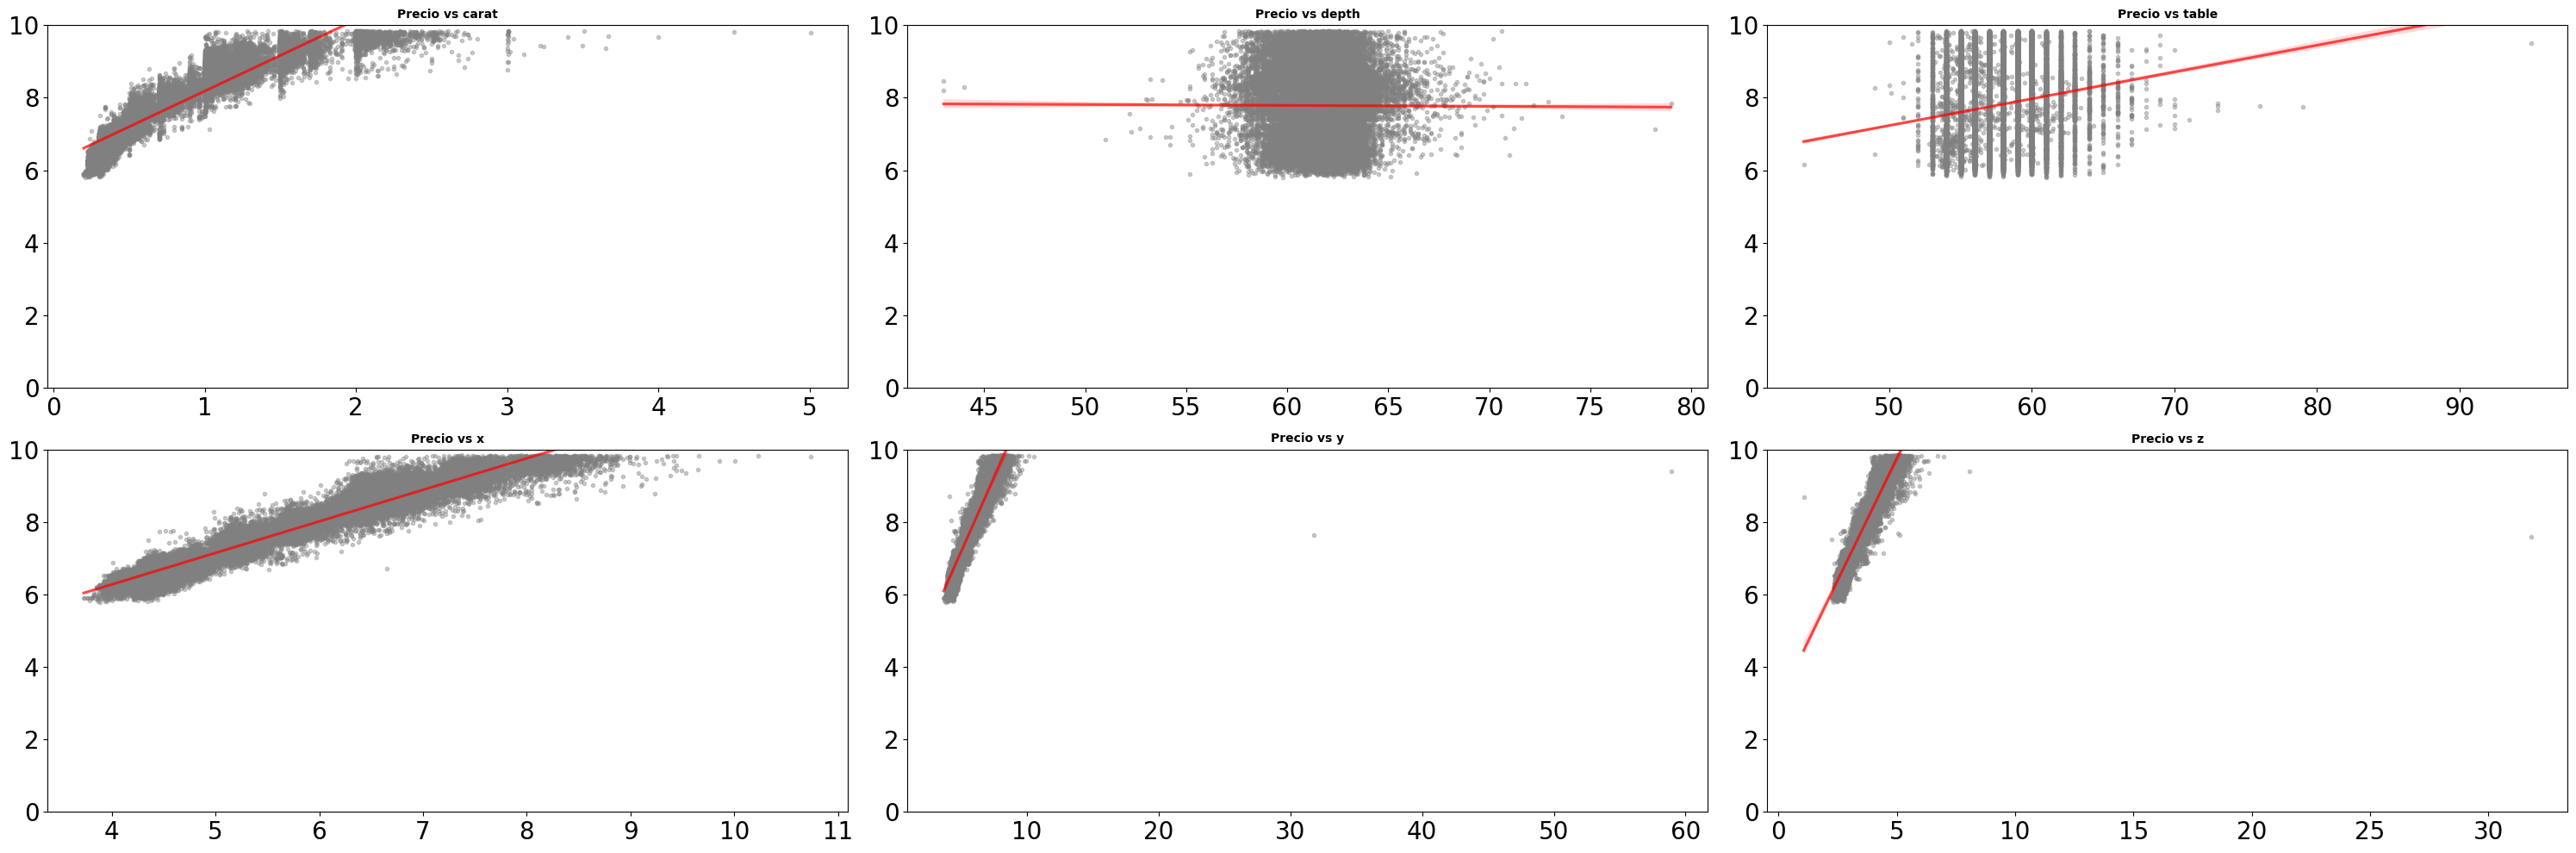

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat

columnas_numeric = df.select_dtypes(include=np.number).columns
columnas_numeric = columnas_numeric.drop("price")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x=df[colum],
        y=df["price"],
        color="gray",
        marker=".",
        scatter_kws={"alpha": 0.4},
        line_kws={"color": "red", "alpha": 0.7},
        ax=axes[i]
    )
    
    axes[i].set_title(f"Precio vs {colum}", fontsize=10, fontweight="bold")
    axes[i].tick_params(labelsize=20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
    # Establecer límite en el eje y
    axes[i].set_ylim(0, 10)

fig.tight_layout()

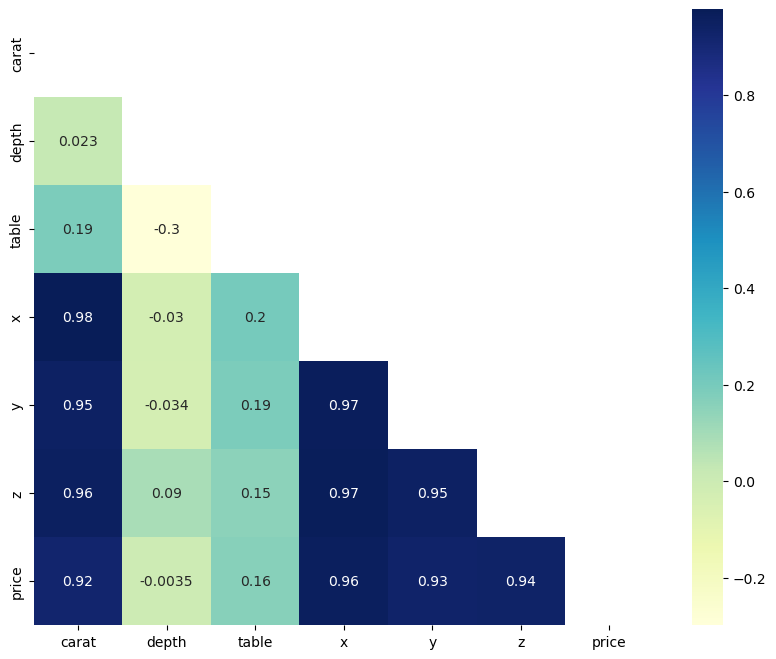

In [17]:
# creamos un dataframe todo de unos de la misma forma que nuestra matriz de correlación

mask = np.triu(np.ones_like(df.corr(numeric_only=True), dtype = np.bool_))
mask

sns.heatmap(df.corr(numeric_only = True), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

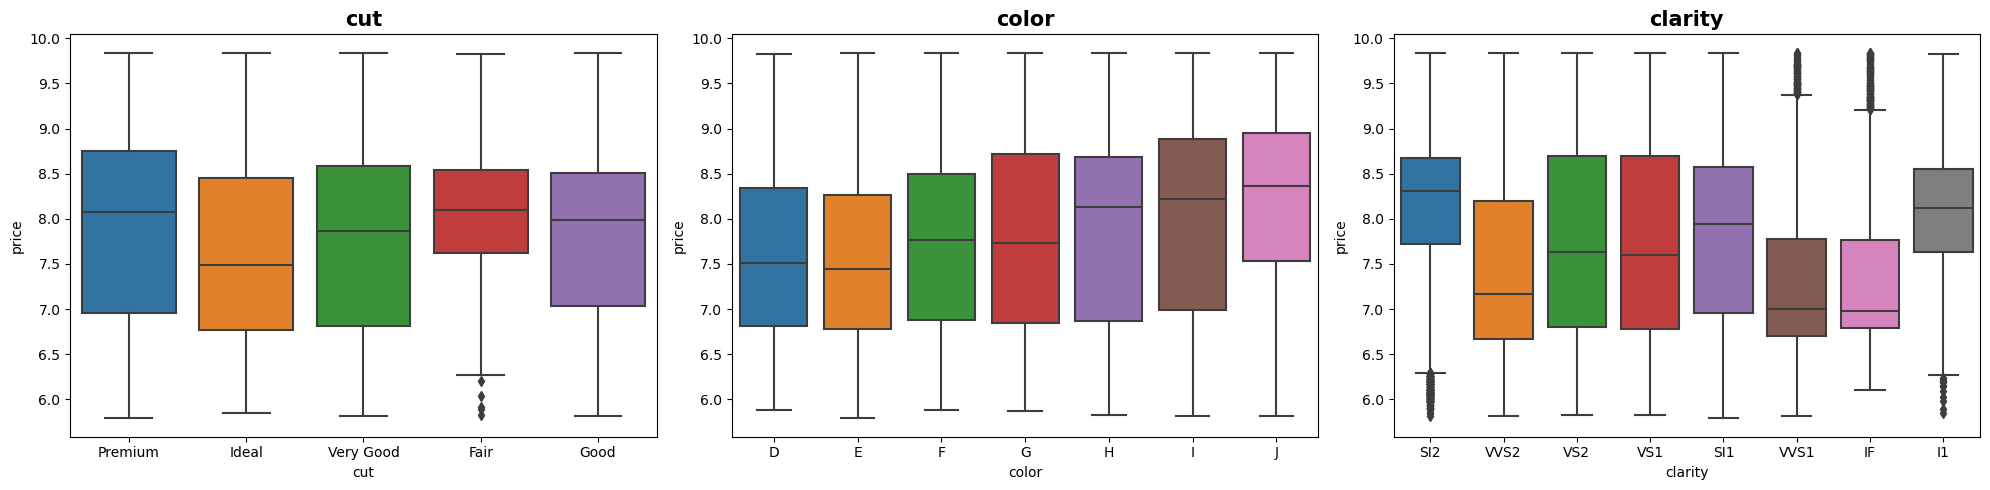

In [18]:
# Gráfico para cada variable cualitativa
# ==============================================================================

fig, axes = plt.subplots(1, 3, figsize = (20,5))


columnas_object = df.select_dtypes(include = "object").columns

for i, colum in enumerate(columnas_object):
    sns.boxplot(x=colum, y="price", data=df,ax=axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")

    
fig.tight_layout();

In [19]:
# Guardamos cambios

df.to_csv('../01_data/train_sin_nulos.csv')